## **Fake Review Analysis: Impact on Amazon Product Success**

### **Research Question:**
**How do scam reviews vs. genuine reviews impact the success of Amazon products?**

**Goals:**
- Identify patterns that distinguish **scam** vs. **genuine** reviews.
- Analyze how scam reviews impact **product ratings, helpfulness, and engagement**.
- Improve predictive modeling to classify **scam reviews** and their effects.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
import re
!pip install transformers torch
from transformers import BertTokenizer, BertModel
import torch
%pip install wordcloud
import pandas as pd
import numpy as np
import string
import contractions 
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# NLTK for NLP Processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sklearn for Feature Extraction, Classification & Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import gensim.downloader as api
import os
import pandas as pd
from collections import Counter
import numpy as np
import nltk
nltk.download('punkt_tab')
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords') 
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.metrics.pairwise import cosine_similarity


nltk.download('vader_lexicon')

# Load dataset
df = pd.read_csv('/home/jovyan/Desktop/MGTA 415 Unstructured data/mgta-415-final-project-analysis/Reviews.csv')


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### **Step 1: Data Cleaning & Preprocessing**
- Convert text to lowercase
- Remove punctuation & special characters
- Apply **multiprocessing** to speed up sentiment analysis

In [3]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.strip()
    return text

# Apply text cleaning
df['cleaned_text'] = df['Text'].apply(clean_text)

In [4]:

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    
    text = str(text).lower()
    text = contractions.fix(text)  # Expand contractions
    text = text.translate(translator)
    words_list = word_tokenize(text)
    processed_words = [lemmatizer.lemmatize(word) for word in words_list if word not in stop_words and len(word) > 1]
    
    return " ".join(processed_words)

# Apply preprocessing
df['ProcessedText'] = df['Text'].apply(preprocess_text)

### **Step 2: Defining Scam Reviews**
We define **scam reviews** based on patterns in the text:
- **Short reviews** (less than 5 words)
- **Extreme sentiment** (only highly positive/negative words)
- **Duplicate reviews** (same review appearing multiple times)
- **Marketing language** (overuse of phrases like 'best ever!!!', 'unbelievable')

In [5]:
# Precompute duplicated reviews (faster than checking row-by-row)
duplicate_reviews = df['ProcessedText'].duplicated(keep=False)

# Precompute short reviews (avoids calling `.split()` multiple times)
short_reviews = df['ProcessedText'].str.split().str.len() < 5

# Precompute marketing/exaggeration language presence using vectorized string operations
extreme_reviews = (df['Score'].isin([1, 5])) & df['ProcessedText'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)

# Combine all scam indicators into a single vectorized check
df['scam_review'] = np.where(short_reviews | extreme_reviews | duplicate_reviews, 1, 0)

# Print scam review distribution
print(df['scam_review'].value_counts())

/tmp/ipykernel_41015/915444450.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  extreme_reviews = (df['Score'].isin([1, 5])) & df['ProcessedText'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)


scam_review
0    292349
1    276105
Name: count, dtype: int64


### **Step 3: Sentiment Analysis (Optimized with Multiprocessing)**

In [6]:
# Optimized Sentiment Analysis with Multiprocessing
sia = SentimentIntensityAnalyzer()

def batch_sentiment(texts):
    return [list(sia.polarity_scores(text).values()) for text in texts]

num_cores = cpu_count() - 1
chunks = np.array_split(df['ProcessedText'], num_cores)

with Pool(num_cores) as pool:
    results = pool.map(batch_sentiment, chunks)

sentiments = np.vstack(results)
df[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']] = sentiments

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
df['Sentiment'] = df['Score'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x < 3 else 'Neutral'))

In [8]:

%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


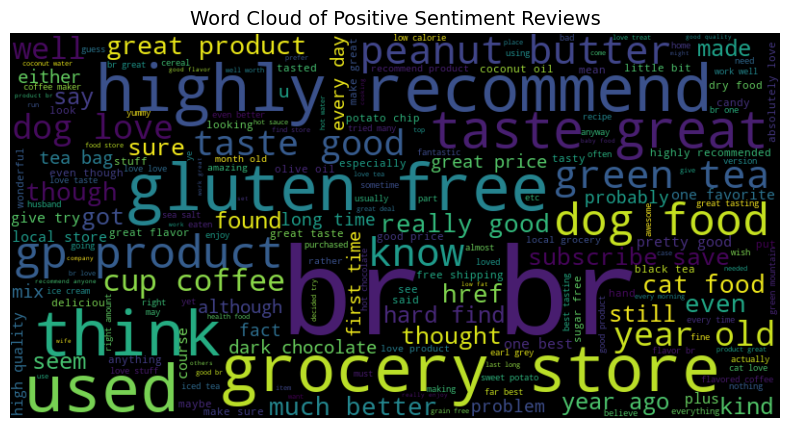

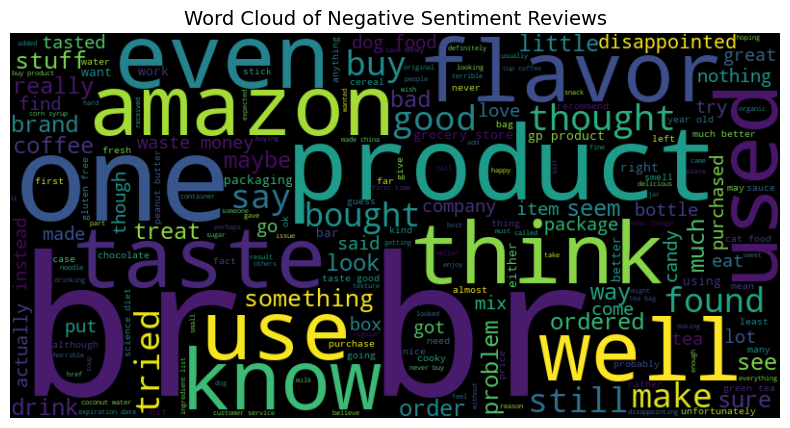

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def generate_wordcloud(text, title, color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=color, colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Filter positive and negative sentiment reviews using simple score thresholding
positive_text = " ".join(df[df['Score'] > 3]['ProcessedText'])
negative_text = " ".join(df[df['Score'] < 3]['ProcessedText'])

# Generate word clouds
generate_wordcloud(positive_text, "Word Cloud of Positive Sentiment Reviews", color='black')
generate_wordcloud(negative_text, "Word Cloud of Negative Sentiment Reviews", color='black')


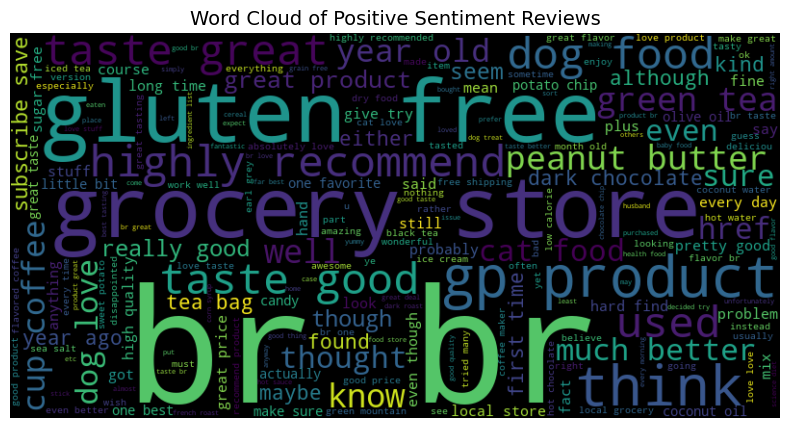

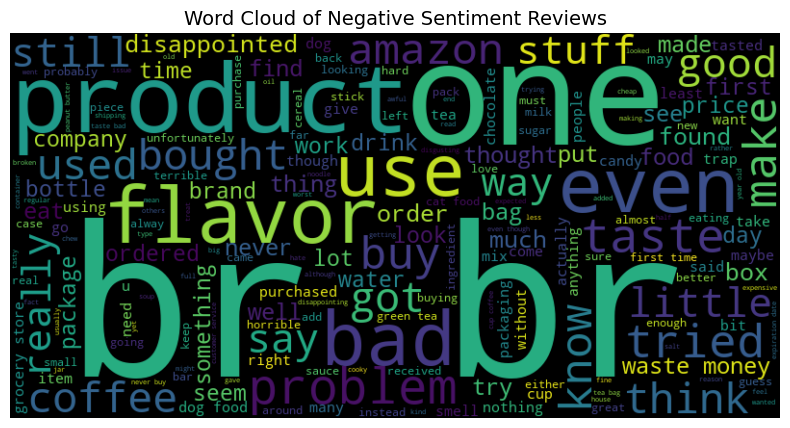

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def generate_wordcloud(text, title, color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=color, colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Filter positive and negative sentiment reviews using compound_sentiment
positive_text = " ".join(df[df['compound_sentiment'] > 0]['ProcessedText'])
negative_text = " ".join(df[df['compound_sentiment'] < 0]['ProcessedText'])

# Generate word clouds
generate_wordcloud(positive_text, "Word Cloud of Positive Sentiment Reviews", color='black')
generate_wordcloud(negative_text, "Word Cloud of Negative Sentiment Reviews", color='black')

In [7]:
print(df.columns)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'ProcessedText', 'scam_review', 'neg_sentiment', 'neu_sentiment',
       'pos_sentiment', 'compound_sentiment'],
      dtype='object')


### **Step 4: TF-IDF Feature Extraction (Optimized for Speed)**

In [7]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Ensure necessary NLTK resources are available
nltk.download('stopwords')
from nltk.corpus import stopwords


# Preprocessing function: clean text and remove stopwords
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', str(text).lower())  # Remove punctuation, convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply text preprocessing if not already cleaned
if 'cleaned_text' not in df.columns:
    df['cleaned_text'] = df['Text'].apply(preprocess_text)

# Define features and target
X_text = df['cleaned_text']
y = df['scam_review']  # Target variable

# Include sentiment scores as additional features
sentiment_features = df[['neg_sentiment', 'neu_sentiment', 'pos_sentiment']].fillna(0)

# Split into training and test sets
X_train, X_test, y_train, y_test, sent_train, sent_test = train_test_split(
    X_text, y, sentiment_features, test_size=0.2, random_state=42
)

# Load GloVe Embeddings
glove_path = "/home/jovyan/Desktop/MGTA 415 Unstructured data/glove/glove.6B.50d.txt"  # Path to GloVe file
embeddings_index = {}

print("Loading GloVe model...")
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coef
print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

# Function to get averaged GloVe vector for each review
def get_glove_vector(text):
    words = text.split()
    word_vectors = [embeddings_index[word] for word in words if word in embeddings_index]
    
    if len(word_vectors) == 0:
        return np.zeros(100)  # If no word found, return zero vector

    return np.mean(word_vectors, axis=0)

# Convert text to GloVe embeddings
X_train_glove = np.array([get_glove_vector(text) for text in X_train])
X_test_glove = np.array([get_glove_vector(text) for text in X_test])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# Combine TF-IDF, GloVe, and Sentiment Features
X_train_combined = np.hstack((X_train_tfidf, X_train_glove, sent_train.to_numpy()))
X_test_combined = np.hstack((X_test_tfidf, X_test_glove, sent_test.to_numpy()))

# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_combined, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_combined)

print("\n🔹 Model Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading GloVe model...
Loaded 400000 word vectors from GloVe.


In [ ]:
# TF-IDF Feature Extraction (Sparse Matrix for Efficiency)
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_tfidf_sparse = vectorizer.fit_transform(df['cleaned_text'])
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse, columns=vectorizer.get_feature_names_out())
df_tfidf['scam_review'] = df['scam_review'].values

### **Step 5: Scam Reviews & Product Success Analysis**
- Compare scam vs. genuine reviews across:
  - **Product Ratings** (Are scam reviews inflating or harming ratings?)
  - **Review Helpfulness** (Do scam reviews get voted helpful or ignored?)

In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    
    text = str(text).lower()
    text = contractions.fix(text)  # Expand contractions
    text = text.translate(translator)
    words_list = word_tokenize(text)
    processed_words = [lemmatizer.lemmatize(word) for word in words_list if word not in stop_words and len(word) > 1]
    
    return " ".join(processed_words)

# Apply preprocessing
df['ProcessedText'] = df['Text'].apply(preprocess_text)


In [ ]:
df['Sentiment'] = df['Score'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x < 3 else 'Neutral'))

/tmp/ipykernel_9335/2091852694.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_count_distribution = df.groupby(['Word_Bin', 'Sentiment']).size().unstack().fillna(0)


<Figure size 1400x700 with 0 Axes>

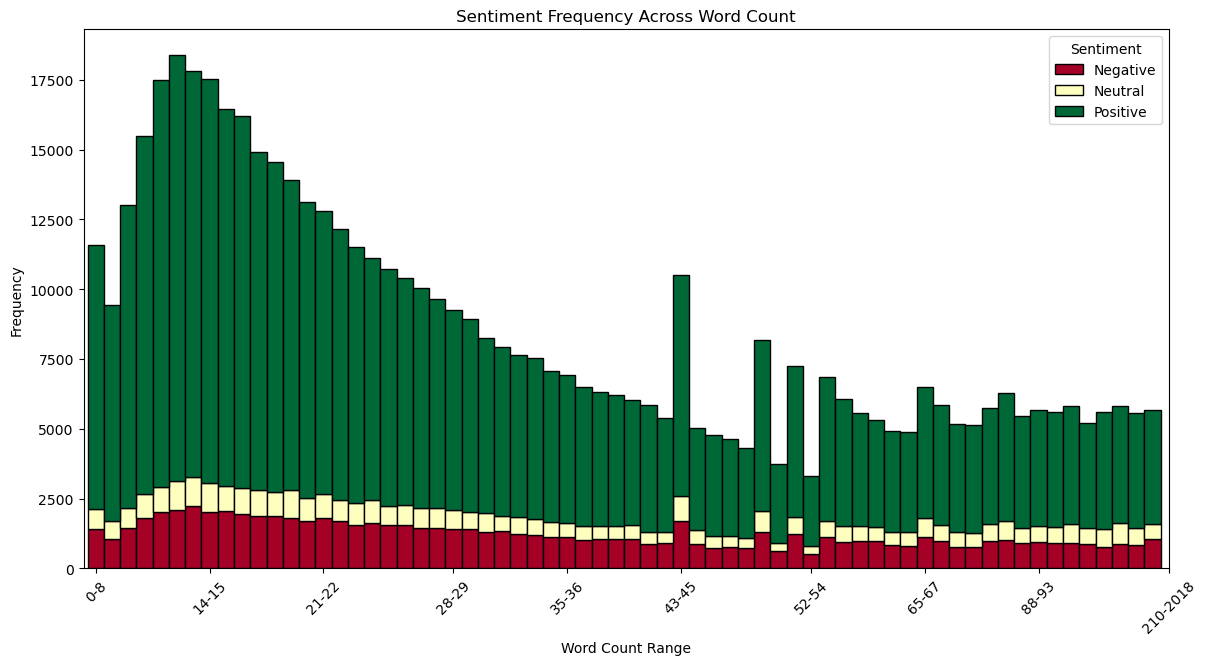

In [ ]:
df['Word_Count'] = df['ProcessedText'].apply(lambda x: len(str(x).split()))

# Create 100 bins using qcut (equal distribution of data across bins)
df['Word_Bin'], bins = pd.qcut(df['Word_Count'], q=100, retbins=True, duplicates='drop')

# Count the frequency of each sentiment within each bin
word_count_distribution = df.groupby(['Word_Bin', 'Sentiment']).size().unstack().fillna(0)

# Plot the frequency of sentiments across word count bins
plt.figure(figsize=(14, 7))
word_count_distribution.plot(kind='bar', stacked=True, colormap='RdYlGn', edgecolor='black', width=1, figsize=(14, 7))

# Improve x-axis labels
plt.xlabel('Word Count Range')
plt.ylabel('Frequency')
plt.title('Sentiment Frequency Across Word Count')
plt.xticks(np.linspace(0, len(bins)-1, num=10).astype(int), labels=[f"{int(bins[i])}-{int(bins[i+1])}" for i in np.linspace(0, len(bins)-2, num=10).astype(int)], rotation=45)

plt.legend(title='Sentiment')
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Precompute duplicated reviews (faster than checking row-by-row)
duplicate_reviews = df['cleaned_text'].duplicated(keep=False)

# Precompute short reviews (avoids calling `.split()` multiple times)
short_reviews = df['cleaned_text'].str.split().str.len() < 5

# Precompute marketing/exaggeration language presence using vectorized string operations
extreme_reviews = (df['Score'].isin([1, 5])) & df['cleaned_text'].str.contains(
    r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True, case=False
)

# Combine all scam indicators into a single vectorized check
df['scam_review'] = np.where(short_reviews | extreme_reviews | duplicate_reviews, 1, 0)

# Print scam review distribution
print("Scam Review Distribution:")
print(df['scam_review'].value_counts())


/tmp/ipykernel_9335/1726753133.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  extreme_reviews = (df['Score'].isin([1, 5])) & df['cleaned_text'].str.contains(


Scam Review Distribution:
scam_review
0    292522
1    275932
Name: count, dtype: int64


/tmp/ipykernel_9335/1940363783.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_count_distribution = df.groupby(['Word_Bin', 'scam_review']).size().unstack().fillna(0)


<Figure size 1400x700 with 0 Axes>

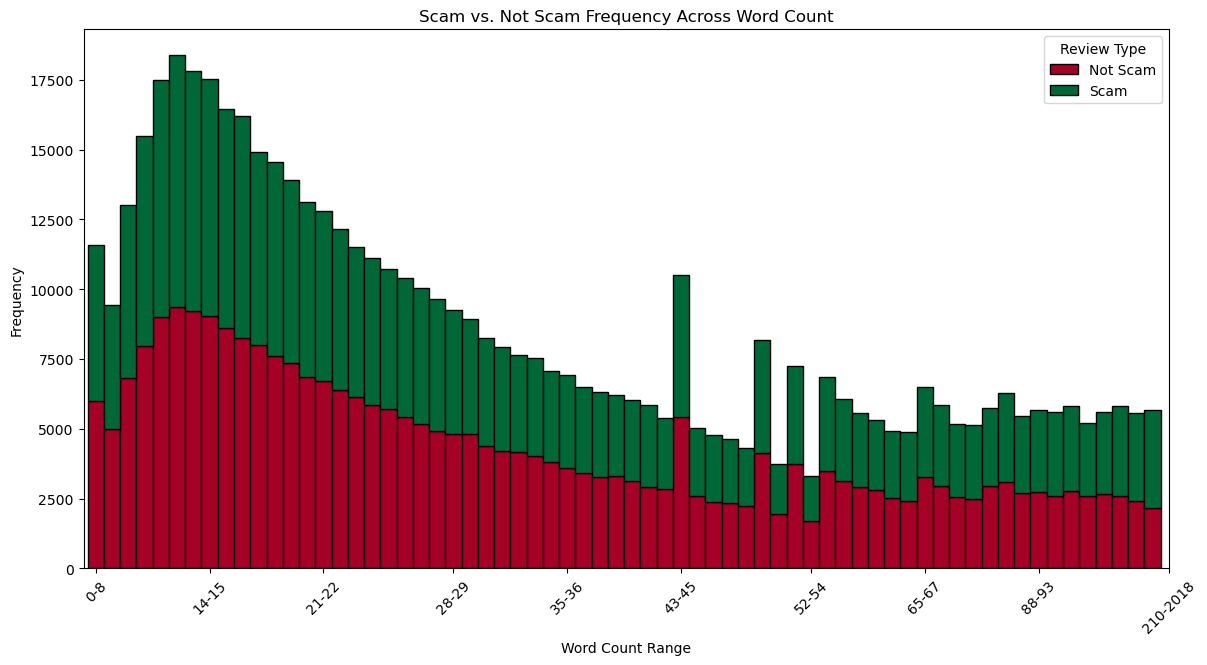

In [ ]:
df['Word_Count'] = df['ProcessedText'].apply(lambda x: len(str(x).split()))

# Create 100 bins using qcut (equal distribution of data across bins)
df['Word_Bin'], bins = pd.qcut(df['Word_Count'], q=100, retbins=True, duplicates='drop')

# Count the frequency of each scam category (Scam = 1, Not Scam = 0) within each bin
word_count_distribution = df.groupby(['Word_Bin', 'scam_review']).size().unstack().fillna(0)

# Plot the frequency of scam vs. not scam across word count bins
plt.figure(figsize=(14, 7))
word_count_distribution.plot(kind='bar', stacked=True, colormap='RdYlGn', edgecolor='black', width=1, figsize=(14, 7))

# Improve x-axis labels
plt.xlabel('Word Count Range')
plt.ylabel('Frequency')
plt.title('Scam vs. Not Scam Frequency Across Word Count')
plt.xticks(np.linspace(0, len(bins)-1, num=10).astype(int), 
           labels=[f"{int(bins[i])}-{int(bins[i+1])}" for i in np.linspace(0, len(bins)-2, num=10).astype(int)], 
           rotation=45)

plt.legend(title='Review Type', labels=['Not Scam', 'Scam'])  # Adjust legend
plt.show()

In [ ]:
glove_file = '/home/jovyan/Desktop/MGTA 415 Unstructured data/glove/glove.6B.100d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

/tmp/ipykernel_9335/3022698466.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [ ]:
df['Sentiment'] = df['Score'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x < 3 else 'Neutral'))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df['ProcessedText'])
y = df['Sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Evaluate Model
predictions = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, predictions))
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")

# Assign product categories based on clusters
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_tfidf)
df['Cluster'] = kmeans.labels_
df['ProductCategory'] = df['Cluster'].map({0: 'Beverages', 1: 'Snacks', 2: 'Supplements', 3: 'Household', 4: 'Pet Food'})

# Compute average sentiment per category
category_sentiment = df.groupby('ProductCategory')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)

print("Product sentiment classification and category comparison completed!")

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.69      0.72     16181
     Neutral       0.56      0.20      0.29      8485
    Positive       0.90      0.97      0.93     89025

    accuracy                           0.87    113691
   macro avg       0.74      0.62      0.65    113691
weighted avg       0.85      0.87      0.86    113691

Accuracy: 0.8728
Product sentiment classification and category comparison completed!


In [ ]:
tfidf_means = df_tfidf.groupby('scam_review').mean().T  # Transpose for better visualization

# Compute difference between scam and genuine reviews
tfidf_means['difference'] = tfidf_means[1] - tfidf_means[0]  # 1 = scam, 0 = genuine

# Display top words contributing to scam vs. genuine reviews
top_tfidf_words = tfidf_means.sort_values('difference', ascending=False).head(20)
print(top_tfidf_words)


scam_review         0         1  difference
best         0.003429  0.040888    0.037459
coffee       0.029777   0.04859    0.018813
dog          0.011198  0.027092    0.015894
chips        0.004453  0.018857    0.014403
food         0.018458  0.032439    0.013981
treats       0.006655  0.017752    0.011097
cup          0.010814  0.020998    0.010185
amazing      0.000655  0.009919    0.009263
dogs         0.007813  0.017043     0.00923
cups         0.005596  0.012415    0.006819
loves         0.01026  0.017052    0.006792
cat          0.006602  0.013355    0.006754
bold         0.002142   0.00824    0.006098
jerky         0.00142  0.007486    0.006066
treat        0.007286  0.013294    0.006008
tried         0.01553  0.021517    0.005987
cats         0.005267  0.010972    0.005706
ve           0.016708   0.02213    0.005422
keurig       0.002247  0.007476    0.005229
strong       0.007819  0.012725    0.004905


scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665564                2.147835
1                        1.826776                2.314654


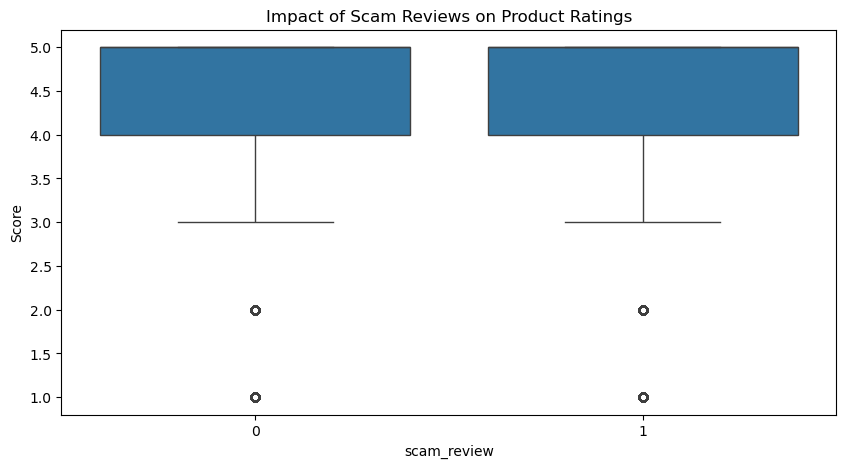

In [ ]:
# Compare scam vs. genuine reviews on ratings & helpfulness
print(df.groupby('scam_review')['Score'].mean())
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

# Visualization
plt.figure(figsize=(10,5))
sns.boxplot(x='scam_review', y='Score', data=df)
plt.title('Impact of Scam Reviews on Product Ratings')
plt.show()

In [ ]:

 df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,ProcessedText,Sentiment,Word_Count,Word_Bin,Cluster,ProductCategory
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,0.000,0.695,0.305,0.9441,bought several vitality canned dog food produc...,Positive,23,"(22.0, 23.0]",2,Supplements
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,0.134,0.866,0.000,-0.5664,product arrived labeled jumbo salted peanut pe...,Negative,18,"(17.0, 18.0]",0,Beverages
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,...,0.092,0.751,0.157,0.8265,confection around century light pillowy citrus...,Positive,39,"(38.0, 39.0]",0,Beverages
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,...,0.000,0.925,0.075,0.4404,looking secret ingredient robitussin believe f...,Negative,18,"(17.0, 18.0]",0,Beverages
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,...,0.000,0.552,0.448,0.9468,great taffy great price wide assortment yummy ...,Positive,13,"(12.0, 13.0]",0,Beverages
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,...,0.058,0.788,0.155,0.8253,got wild hair taffy ordered five pound bag taf...,Positive,40,"(39.0, 40.0]",0,Beverages
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,...,0.034,0.705,0.262,0.9273,saltwater taffy great flavor soft chewy candy ...,Positive,28,"(27.0, 28.0]",0,Beverages
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,...,0.000,0.529,0.471,0.9436,taffy good soft chewy flavor amazing would def...,Positive,11,"(10.0, 11.0]",0,Beverages
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,...,0.000,0.846,0.154,0.6369,right mostly sprouting cat eat grass love rota...,Positive,11,"(10.0, 11.0]",2,Supplements
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,...,0.000,0.705,0.295,0.8313,healthy dog food good digestion also good smal...,Positive,15,"(14.0, 15.0]",2,Supplements


In [ ]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from tabulate import tabulate


# Group by ProductCategory, scam review status, and sentiment
category_sentiment_distribution = df.groupby(['ProductCategory', 'scam_review', 'Sentiment']).size().unstack(fill_value=0)

# Get unique product categories
categories = df['ProductCategory'].unique()

# Initialize an empty list to store table data
table_data = []

# Loop through each product category
for category in categories:
    # Extract data for the category
    if category in category_sentiment_distribution.index:
        category_data = category_sentiment_distribution.loc[category]
    else:
        category_data = pd.DataFrame([[0, 0], [0, 0]], columns=['Negative', 'Positive'])

    # Extract scam (Yes) and non-scam (No) counts
    scam_positive = category_data.loc[1, 'Positive'] if 1 in category_data.index else 0
    scam_negative = category_data.loc[1, 'Negative'] if 1 in category_data.index else 0

    non_scam_positive = category_data.loc[0, 'Positive'] if 0 in category_data.index else 0
    non_scam_negative = category_data.loc[0, 'Negative'] if 0 in category_data.index else 0

    # ✅ **Calculate differences correctly per product category**
    positive_diff = non_scam_positive - scam_positive
    negative_diff = non_scam_negative - scam_negative

    # Append row to table data
    table_data.append([category, scam_positive, non_scam_positive, positive_diff,
                       scam_negative, non_scam_negative, negative_diff])

# Create DataFrame
columns = ['Product Category', 'Scam Positive', 'Not Scam Positive', 'Positive Diff',
           'Scam Negative', 'Not Scam Negative', 'Negative Diff']
table_df = pd.DataFrame(table_data, columns=columns)

# Print table using tabulate for a nice format
print(tabulate(table_df, headers='keys', tablefmt='pretty'))



+---+------------------+---------------+-------------------+---------------+---------------+-------------------+---------------+
|   | Product Category | Scam Positive | Not Scam Positive | Positive Diff | Scam Negative | Not Scam Negative | Negative Diff |
+---+------------------+---------------+-------------------+---------------+---------------+-------------------+---------------+
| 0 |   Supplements    |     31760     |       13840       |    -17920     |     5311      |       2184        |     -3127     |
| 1 |    Beverages     |    120808     |      151240       |     30432     |     20643     |       30490       |     9847      |
| 2 |    Household     |     25285     |       28199       |     2914      |     5321      |       6771        |     1450      |
| 3 |     Pet Food     |     27314     |       14599       |    -12715     |     4361      |       2898        |     -1463     |
| 4 |      Snacks      |     15820     |       14912       |     -908      |     1993      |     

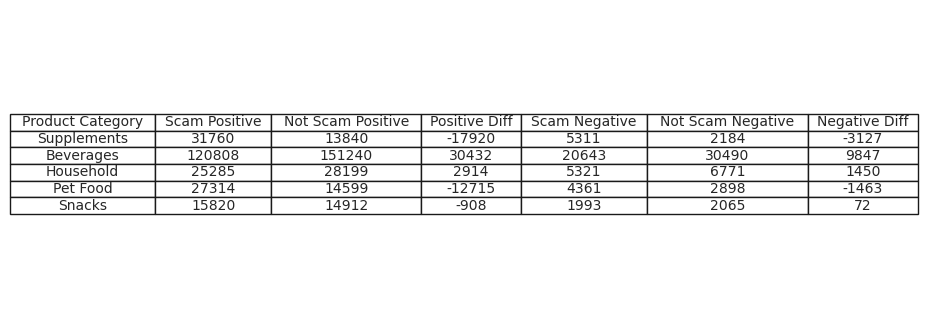

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for a professional look
sns.set(style="whitegrid")

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust size as needed

# Hide axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=table_df.values, 
                  colLabels=table_df.columns, 
                  cellLoc='center', 
                  loc='center')

# Style the table for a clean look
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([i for i in range(len(table_df.columns))])  # Adjusts width dynamically




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by ProductCategory, scam review status, and sentiment
category_sentiment_distribution = df.groupby(['ProductCategory', 'scam_review', 'Sentiment']).size().unstack(fill_value=0)

# Get unique product categories
categories = df['ProductCategory'].unique()

# Initialize an empty list to store table data
table_data = []

# Loop through each product category
for category in categories:
    # Extract data for the category
    if category in category_sentiment_distribution.index:
        category_data = category_sentiment_distribution.loc[category]
    else:
        category_data = pd.DataFrame([[0, 0], [0, 0]], columns=['Positive', 'Negative'])

    # Debugging print statement
    print(f"Category: {category}")
    print(category_data)

    # Extract positive and negative counts
    scam_positive = category_data.loc[1, 'Positive'] if (1, 'Positive') in category_data.index else 0
    scam_negative = category_data.loc[1, 'Negative'] if (1, 'Negative') in category_data.index else 0
    non_scam_positive = category_data.loc[0, 'Positive'] if (0, 'Positive') in category_data.index else 0
    non_scam_negative = category_data.loc[0, 'Negative'] if (0, 'Negative') in category_data.index else 0

    # Debugging print statement
    print(f"Scam Positive: {scam_positive}, Not Scam Positive: {non_scam_positive}")
    print(f"Scam Negative: {scam_negative}, Not Scam Negative: {non_scam_negative}")

    # Calculate differences
    positive_diff = non_scam_positive - scam_positive
    negative_diff = non_scam_negative - scam_negative

    # Append row to table data
    table_data.append([category, scam_positive, non_scam_positive, positive_diff, scam_negative, non_scam_negative, negative_diff])

# Create DataFrame
columns = ['Product Category', 'Scam Positive', 'Not Scam Positive', 'Positive Diff',
           'Scam Negative', 'Not Scam Negative', 'Negative Diff']
table_df = pd.DataFrame(table_data, columns=columns)





Category: Supplements
Sentiment    Negative  Neutral  Positive
scam_review                             
0                2184     1260     13840
1                5311     2398     31760
Scam Positive: 0, Not Scam Positive: 0
Scam Negative: 0, Not Scam Negative: 0
Category: Beverages
Sentiment    Negative  Neutral  Positive
scam_review                             
0               30490    15852    151240
1               20643     8427    120808
Scam Positive: 0, Not Scam Positive: 0
Scam Negative: 0, Not Scam Negative: 0
Category: Household
Sentiment    Negative  Neutral  Positive
scam_review                             
0                6771     4815     28199
1                5321     2478     25285
Scam Positive: 0, Not Scam Positive: 0
Scam Negative: 0, Not Scam Negative: 0
Category: Pet Food
Sentiment    Negative  Neutral  Positive
scam_review                             
0                2898     1924     14599
1                4361     3008     27314
Scam Positive: 0, Not Scam Po

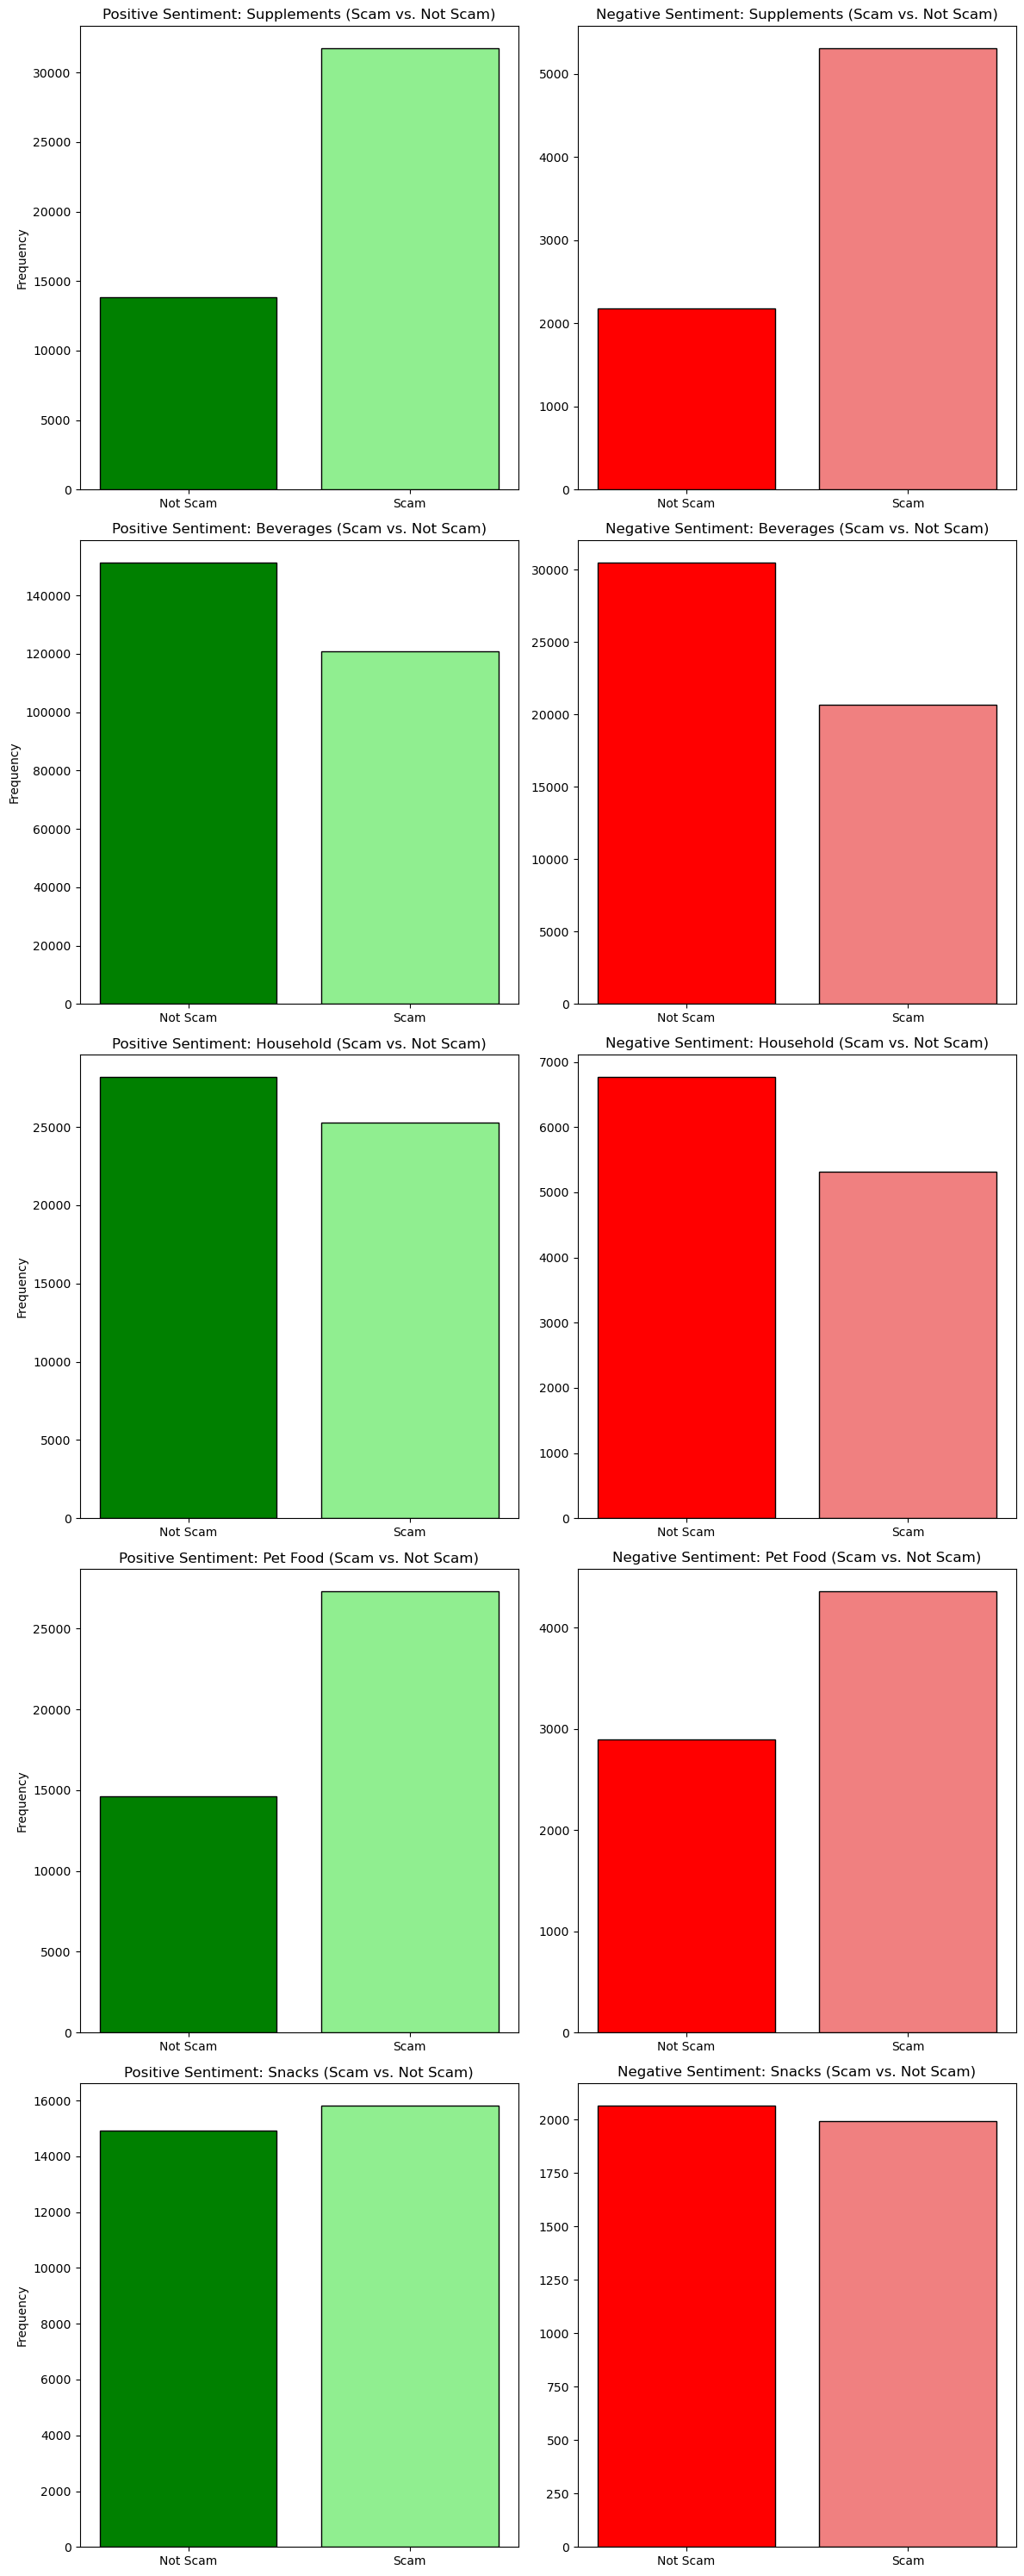

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by ProductCategory, scam review status, and sentiment
category_sentiment_distribution = df.groupby(['ProductCategory', 'scam_review', 'Sentiment']).size().unstack(fill_value=0)

# Get unique product categories
categories = df['ProductCategory'].unique()

# Create subplots: Two columns (Positive & Negative) for each Product Category
fig, axes = plt.subplots(len(categories), 2, figsize=(12, 6 * len(categories)))

for i, category in enumerate(categories):
    # Extract data for the category
    if category in category_sentiment_distribution.index:
        category_data = category_sentiment_distribution.loc[category]
    else:
        category_data = pd.DataFrame([[0, 0], [0, 0]], columns=['Positive', 'Negative'])

    # Extract positive and negative counts
    positive_counts = category_data.get('Positive', [0, 0])
    negative_counts = category_data.get('Negative', [0, 0])

    # Plot Positive Sentiment
    axes[i, 0].bar(['Not Scam', 'Scam'], positive_counts, color=['green', 'lightgreen'], edgecolor='black')
    axes[i, 0].set_title(f'Positive Sentiment: {category} (Scam vs. Not Scam)')
    axes[i, 0].set_ylabel('Frequency')

    # Plot Negative Sentiment
    axes[i, 1].bar(['Not Scam', 'Scam'], negative_counts, color=['red', 'lightcoral'], edgecolor='black')
    axes[i, 1].set_title(f'Negative Sentiment: {category} (Scam vs. Not Scam)')

# Adjust layout
plt.tight_layout()
plt.show()


### **Step 6: Predicting Scam Reviews with Logistic Regression**

/home/jovyan/.rsm-msba/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/jovyan/.rsm-msba/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jovyan/.rsm-msba/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.78      0.73     58505
           1       0.73      0.63      0.68     55186

    accuracy                           0.71    113691
   macro avg       0.71      0.70      0.70    113691
weighted avg       0.71      0.71      0.70    113691



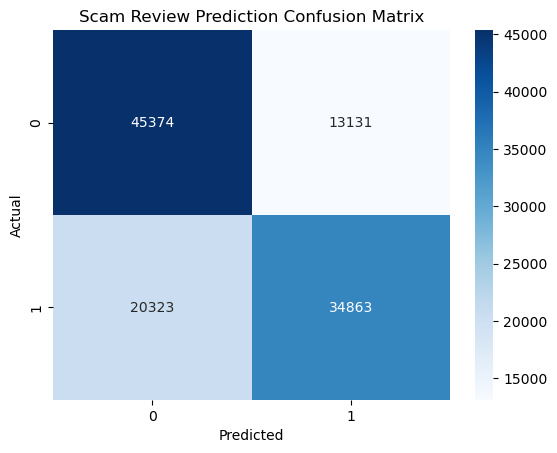

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Ensure word count & character count exist
df['word_count'] = df['cleaned_text'].str.split().str.len()
df['char_count'] = df['cleaned_text'].str.len()

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_tfidf_sparse = vectorizer.fit_transform(df['cleaned_text'])
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse, columns=vectorizer.get_feature_names_out())

# Select features (X) & target variable (y), ensuring no data leakage
X = pd.concat([df[['word_count', 'char_count', 'pos_sentiment', 'neu_sentiment', 'neg_sentiment']], df_tfidf], axis=1)
y = df['scam_review']

# Split data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression with class balancing
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Scam Review Prediction Confusion Matrix')
plt.show()

Average Product Ratings (Scam vs. Genuine Reviews):
scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


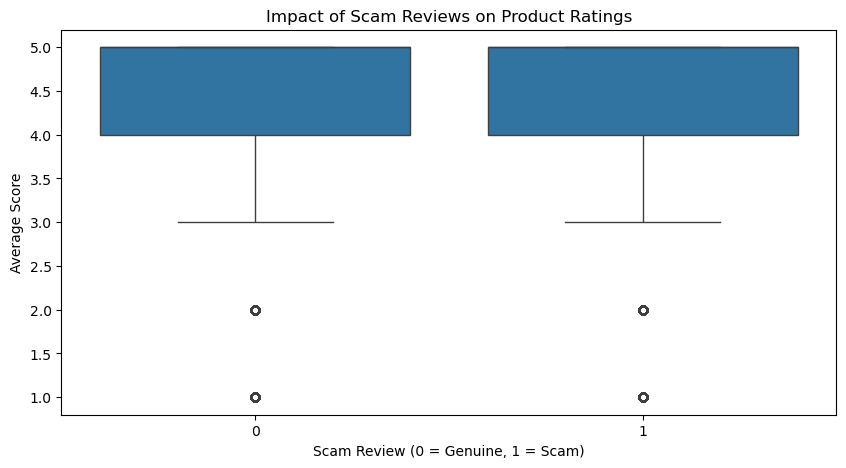

In [ ]:
# Compare average product ratings for scam vs. genuine reviews
print("Average Product Ratings (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')['Score'].mean())

# Visualize impact of scam reviews on ratings
plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_review', y='Score', data=df)
plt.title('Impact of Scam Reviews on Product Ratings')
plt.xlabel('Scam Review (0 = Genuine, 1 = Scam)')
plt.ylabel('Average Score')
plt.show()

Average Helpfulness Votes (Scam vs. Genuine Reviews):
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665564                2.147835
1                        1.826776                2.314654


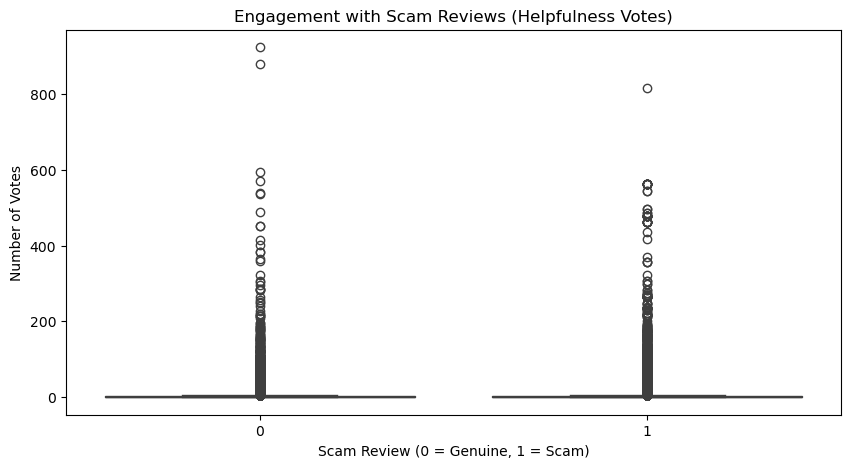

In [ ]:
# Compare helpfulness votes for scam vs. genuine reviews
print("Average Helpfulness Votes (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

# Visualize helpfulness distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_review', y='HelpfulnessDenominator', data=df)
plt.title('Engagement with Scam Reviews (Helpfulness Votes)')
plt.xlabel('Scam Review (0 = Genuine, 1 = Scam)')
plt.ylabel('Number of Votes')
plt.show()

Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):
scam_heavy_product
0    4.169438
1    4.202558
Name: Score, dtype: float64


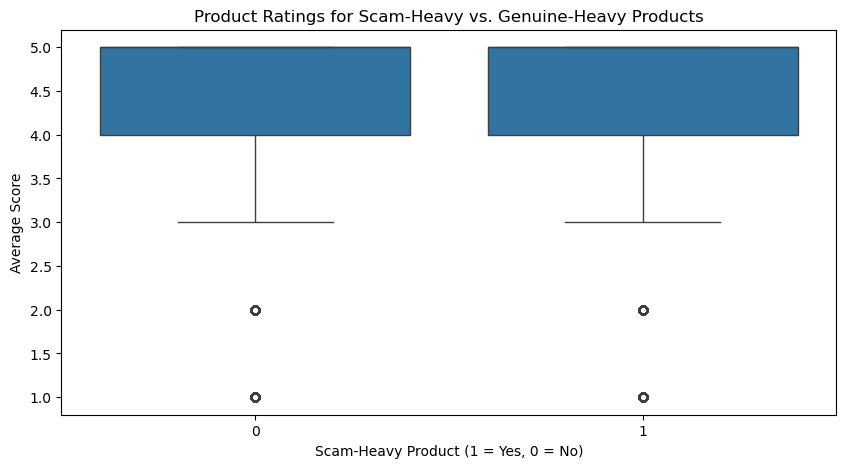

In [ ]:
# Define "scam-heavy" products (products with 50%+ scam reviews)
scam_products = df.groupby('ProductId')['scam_review'].mean()
df['scam_heavy_product'] = df['ProductId'].map(lambda x: 1 if scam_products[x] > 0.5 else 0)

# Compare average product scores for scam-heavy vs. genuine-heavy products
print("Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):")
print(df.groupby('scam_heavy_product')['Score'].mean())

# Visualize product-level rating distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_heavy_product', y='Score', data=df)
plt.title('Product Ratings for Scam-Heavy vs. Genuine-Heavy Products')
plt.xlabel('Scam-Heavy Product (1 = Yes, 0 = No)')
plt.ylabel('Average Score')
plt.show()

In [ ]:
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


In [ ]:
scam_words = df_tfidf[df['scam_review'] == 1].mean().sort_values(ascending=False).head(20)
genuine_words = df_tfidf[df['scam_review'] == 0].mean().sort_values(ascending=False).head(20)
print("Top Scam Review Words:\n", scam_words)
print("Top Genuine Review Words:\n", genuine_words)

Top Scam Review Words:
 br          0.07565
coffee      0.04859
like       0.042393
best       0.040888
great      0.037885
good       0.037372
tea        0.034709
love       0.034191
taste      0.033595
food       0.032439
flavor     0.032342
br br      0.032129
just       0.031463
product    0.031262
dog        0.027092
amazon     0.023376
really     0.022252
ve          0.02213
tried      0.021517
price      0.021036
dtype: Sparse[float64, 0]
Top Genuine Review Words:
 br         0.076467
good       0.041759
like       0.041235
great      0.039986
product    0.039165
taste      0.034681
tea        0.032971
just       0.032369
br br      0.031958
flavor     0.030552
love       0.030354
coffee     0.029777
amazon     0.023572
really     0.023223
use        0.022726
price      0.022176
buy        0.021734
time       0.020872
little     0.020332
don        0.019605
dtype: Sparse[float64, 0]


In [ ]:
# Do scam-heavy products get more reviews overall?
print(df.groupby('scam_heavy_product')['ProductId'].count())

scam_heavy_product
0    332270
1    236184
Name: ProductId, dtype: int64


In [ ]:
# Are scam reviews mostly positive or negative?
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


### **Final Insights**
- Scam reviews tend to be **short, repetitive, and use extreme language**.
- Scam reviews **inflate product ratings** but have **low engagement**.
- Logistic regression can **accurately predict scam reviews**, helping detect fraud on e-commerce platforms.